In [1]:
import lightkurve as lk
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

enlarge_aper = lambda x: np.any(np.asarray(np.gradient(x.astype(float))) != 0, axis=0) | x

def bin(lc, nbins=10):
    """Quick function for binning light curves"""
    x, y, ye = np.asarray([np.hstack([i[:, 0].mean(axis=0),
                                  i[:, 1].mean(axis=0),
                                  ((i[:, 2]**2).sum(axis=0)**0.5)/i[:, 2].shape[0]]) 
                       for i in np.array_split(np.vstack([lc.time.value,
                                                          lc.flux.value,
                                                          lc.flux_err.value]).T, nbins)]).T
    return lk.LightCurve(time=x, flux=y*lc.flux.unit, flux_err=ye*lc.flux_err.unit, label=lc.label, targetid=lc.targetid)


def bin_bkg_columns(tpf):
    """Creates time series for each pixel column in the TPF, outside of the aperture"""
    bigger_pipeline_mask = enlarge_aper(tpf.pipeline_mask)
    bkg = np.median(tpf.flux.value * ~bigger_pipeline_mask[None, :, :], axis=1)
    bkg = bkg[:, bkg.sum(axis=0) != 0]
    
    # Bin and interpolate for a smoother function
    binsize = int(np.round(0.00347/np.median(np.median(np.diff(tpf.time.value)))))
    breaks = np.hstack([0, np.where(np.diff(tpf.time.value) > 0.04)[0] + 1, len(tpf.time)])
    masks = [np.in1d(np.arange(len(tpf.time)), np.arange(a, b)) for a, b in zip(breaks[:-1], breaks[1:])]
    ts, bs = [], []
    for mask in masks:
        ts.append(np.asarray([i.mean() for i in np.array_split(tpf.time.value[mask], int(np.ceil(mask.sum()/binsize)))]))
        bs.append(np.asarray([i.mean(axis=0) for i in np.array_split(bkg[mask], int(np.ceil(mask.sum()/binsize)))]))
    ts, bs = np.hstack(ts), np.vstack(bs)
    return np.asarray([interp1d(ts, b, bounds_error=None, fill_value='extrapolate')(tpf.time.value) for b in bs.T]).T

def correct_transit_light_curve(tpf, bls):
    """Creates a systematics corrected light curve from a TPF, given a BLS object"""
    period, dur, t0 = bls.period_at_max_power.value, bls.duration_at_max_power.value, bls.transit_time_at_max_power.value
    bigger_pipeline_mask = enlarge_aper(tpf.pipeline_mask)

    phase_curve = (np.cos((tpf.time.value - t0) * (2 * np.pi)/period) * 0.5)
    transit = bls.get_transit_mask(period, dur, t0).astype(float)
    eclipse = bls.get_transit_mask(period, dur, t0 + period/2).astype(float)
    
    breaks = list(np.where(np.diff(tpf.time.value) > 0.1)[0] + 1)
    
    #dm1 = lk.DesignMatrix(np.nan_to_num(tpf.flux[:, ~bigger_pipeline_mask]), name='bkg').pca(2).split(breaks)
    bkg = bin_bkg_columns(tpf)
    dm1 = lk.DesignMatrix(bkg, name='bkg').split(breaks)
    dm2 = lk.DesignMatrix(transit[:, None], name='transit')
    dm3 = lk.DesignMatrix((phase_curve + eclipse)[:, None], name='eclipse')                
    dm4 = lk.DesignMatrix(np.nan_to_num(np.vstack([tpf.pos_corr1,
                                                   tpf.pos_corr2,
                                                   tpf.pos_corr1*tpf.pos_corr2]).T), name='centroids').split(breaks)
    spline = lk.designmatrix.create_spline_matrix(tpf.time.jd, n_knots=20).split(breaks)
    dm5 = lk.DesignMatrix(spline.X[:, spline.X.sum(axis=0) > 1e-5], name='spline')
    
    dm = lk.DesignMatrixCollection([dm1, dm2, dm3, dm4, dm5])
    lc = (tpf - np.median(tpf.flux[:, ~bigger_pipeline_mask].value, axis=1)[:, None, None]).to_lightcurve().normalize()
    r = lk.RegressionCorrector(lc)
    clc = r.correct(dm)

    # The RegressionCorrector has fit and removed out simple box model from `dm4`
    # We add the best fit box transit back into the light curve here
    clc += r.diagnostic_lightcurves['transit']
    clc += r.diagnostic_lightcurves['eclipse']
    clc = clc[~r.outlier_mask]
    return clc, r

def get_tpfs(name, quality_bitmask="default"):
    """Obtain the fastest cadence tpfs for a target, and returns them as a collection"""
    tpfs1 = lk.search_targetpixelfile(name, author='SPOC', exptime=20).download_all(quality_bitmask=quality_bitmask)
    tpfs2 = lk.search_targetpixelfile(name, author='SPOC', sector=list(set(list(np.arange(300))) - set(tpfs1.sector)), exptime=120).download_all(quality_bitmask=quality_bitmask)
    # Merge into one collection
    tpfs = lk.TargetPixelFileCollection([*tpfs1] + [*tpfs2])
    # Clip out nan frames
    tpfs = lk.TargetPixelFileCollection([tpf[np.isfinite(tpf.flux.sum(axis=(1, 2))) & np.isfinite(tpf.flux_err.sum(axis=(1, 2)))] for tpf in tpfs])
    # Sort by time
    tpfs = lk.TargetPixelFileCollection([tpfs[i] for i in np.argsort(tpfs.sector)])    
    # Sort add pipeline background back in 
    tpfs = lk.TargetPixelFileCollection([tpf + np.nan_to_num(tpf.flux_bkg) for tpf in tpfs])    
    return tpfs

def get_corrected_lcs(name, period_estimate):
    tpfs = get_tpfs(name)
    corrected_lightcurves = []
    for tpf in tpfs:
        bigger_pipeline_mask = enlarge_aper(tpf.pipeline_mask)
        bkg = np.median(tpf.flux[:, ~bigger_pipeline_mask], axis=1)
        lc = (tpf - bkg[:, None, None]).to_lightcurve()
        bls = lc.to_periodogram(method='bls',
                            minimum_period=period_estimate - 0.05,
                            maximum_period=period_estimate + 0.05,
                            frequency_factor=10,
                            duration=np.linspace(0.01, 0.3, 50));
        period, dur, t0 = bls.period_at_max_power.value, bls.duration_at_max_power.value, bls.transit_time_at_max_power.value
        clc, r = correct_transit_light_curve(tpf, bls)
        corrected_lightcurves.append(clc)
    return lk.LightCurveCollection(corrected_lightcurves)

# WASP-43b

In [ ]:
name = "WASP-43"
period_estimate = 0.8134
clcs = get_corrected_lcs(name, period_estimate)

In [ ]:
bls = clcs.stitch().to_periodogram(method='bls',
                    minimum_period=period_estimate - 0.005,
                    maximum_period=period_estimate + 0.005,
                    frequency_factor=100,
                    duration=np.linspace(0.01, 0.3, 50));
period, dur, t0 = bls.period_at_max_power.value, bls.duration_at_max_power.value, bls.transit_time_at_max_power.value
for clc in clcs:
    ax = clc.fold(period, t0).errorbar(color='grey', ls='', alpha=0.2)
    bin(clc.fold(period, t0), 1000).errorbar(ax=ax, label='Binned')
    ax.set(title=f'{name}, Sector {clc.sector}')

In [4]:
clcs.stitch().to_csv(f'{name}_TESS_CorrectedLC.csv')
clcs.stitch().to_fits(f'{name}_TESS_CorrectedLC.fits')

# WASP-18b

In [5]:
name = "WASP-18"
period_estimate = 0.9414
clcs = get_corrected_lcs(name, period_estimate)

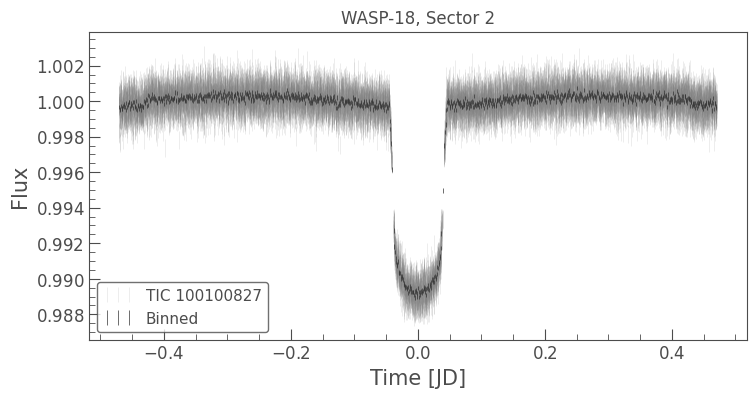

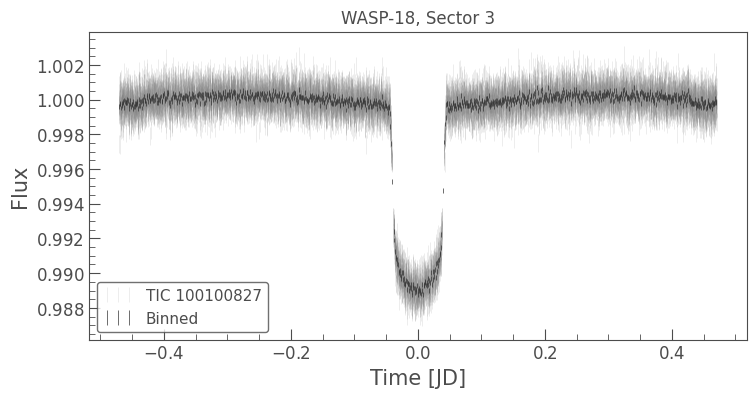

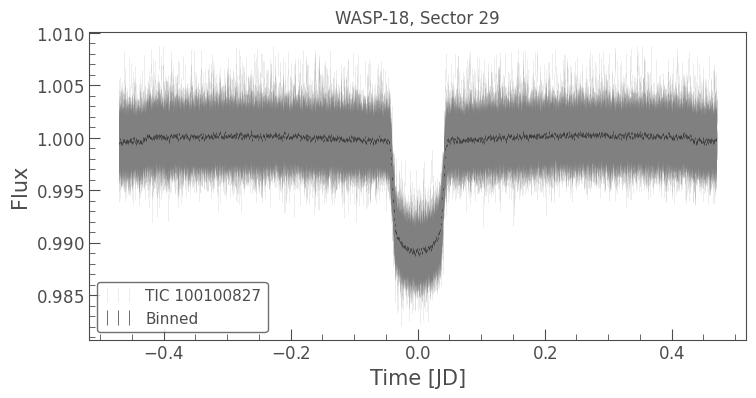

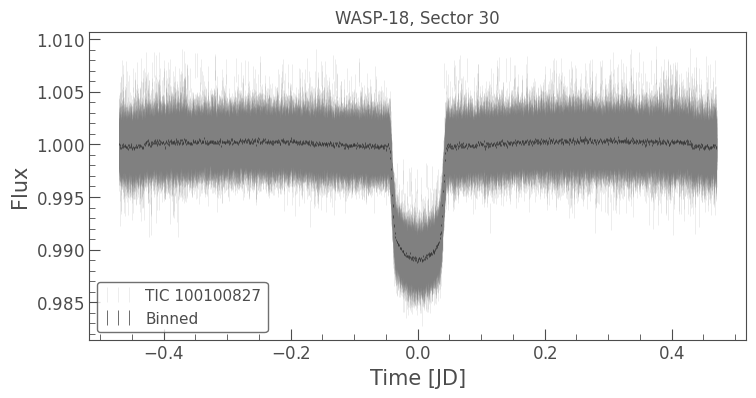

In [6]:
bls = clcs.stitch().to_periodogram(method='bls',
                    minimum_period=period_estimate - 0.005,
                    maximum_period=period_estimate + 0.005,
                    frequency_factor=100,
                    duration=np.linspace(0.01, 0.3, 50));
period, dur, t0 = bls.period_at_max_power.value, bls.duration_at_max_power.value, bls.transit_time_at_max_power.value
for clc in clcs:
    ax = clc.fold(period, t0).errorbar(color='grey', ls='', alpha=0.2)
    bin(clc.fold(period, t0), 1000).errorbar(ax=ax, label='Binned')
    ax.set(title=f'{name}, Sector {clc.sector}')

In [7]:
clcs.stitch().to_csv(f'{name}_TESS_CorrectedLC.csv')
clcs.stitch().to_fits(f'{name}_TESS_CorrectedLC.fits')

# WASP-96b

In [8]:
name='WASP-96'
period_estimate = 3.4246
clcs = get_corrected_lcs(name, period_estimate)

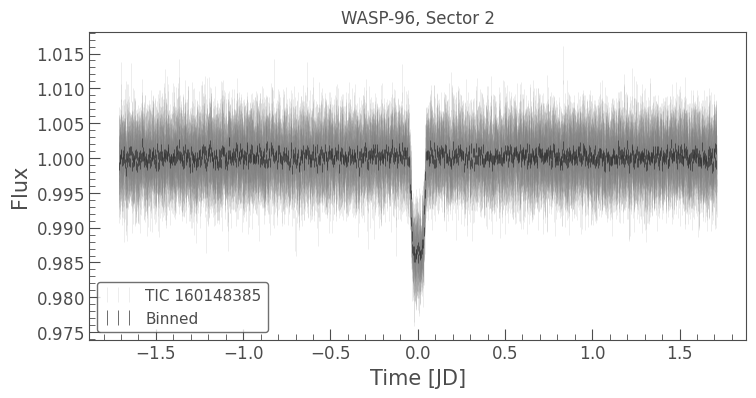

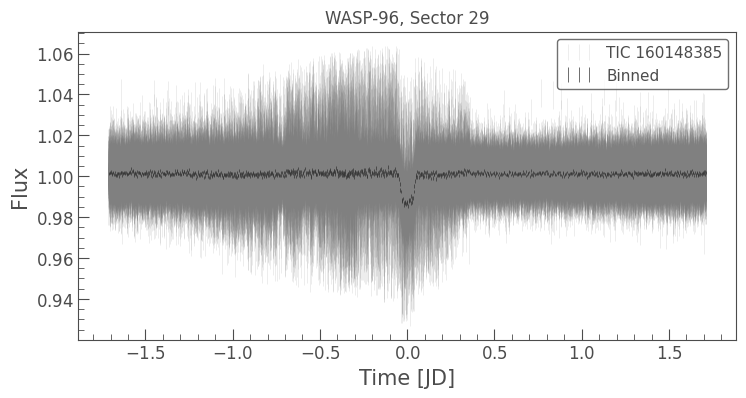

In [9]:
bls = clcs.stitch().to_periodogram(method='bls',
                    minimum_period=period_estimate - 0.005,
                    maximum_period=period_estimate + 0.005,
                    frequency_factor=100,
                    duration=np.linspace(0.01, 0.3, 50));
period, dur, t0 = bls.period_at_max_power.value, bls.duration_at_max_power.value, bls.transit_time_at_max_power.value
for clc in clcs:
    ax = clc.fold(period, t0).errorbar(color='grey', ls='', alpha=0.2)
    bin(clc.fold(period, t0), 1000).errorbar(ax=ax, label='Binned')
    ax.set(title=f'{name}, Sector {clc.sector}')

In [10]:
clcs.stitch().to_csv(f'{name}_TESS_CorrectedLC.csv')
clcs.stitch().to_fits(f'{name}_TESS_CorrectedLC.fits')